# Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from astropy.io import fits

import astropy
import nifty_ls
from astropy.io import fits
from astropy.table import Table
from astropy.timeseries import LombScargle
from astropy.coordinates import SkyCoord
from astropy import units

import indigo
plt.style.use(indigo.mplstyle)

from tqdm import tqdm
import scipy

import multiprocess
import pandas as pd
import sqlite3
import lightkurve
import lightkurve.periodogram

import sys
sys.path.append('/Users/apgautham/Research/03_Packages/')
import WD_models

HR_grid = (-0.6, 1.25, 0.002, 7, 15, 0.01)
model_DA  = WD_models.load_model(low_mass_model='Bedard2020',
                             middle_mass_model='Bedard2020',
                             high_mass_model='Bedard2020', 
                              atm_type='H', 
                              HR_bands=('bp3-rp3', 'G3'),
                              HR_grid=HR_grid,)

mass_logteff_logg_DA = WD_models.interp_xy_z_func(x=model_DA['mass_array'],\
                                               y=model_DA['logteff'],\
                                               z=model_DA['logg'],\
                                               interp_type='linear')


/opt/miniconda3/envs/research_base/lib/python3.12/site-packages/lightkurve/prf/__init__.py:7: UserWarning: Warning: the tpfmodel submodule is not available without oktopus installed, which requires a current version of autograd. See #1452 for details.
  warnings.warn(


# LSST properties

## Photometric error

In [2]:
# Single visit error

data = \
{
    'u': {'gamma': 0.038, 'm5': 23.78},
    'g': {'gamma': 0.039, 'm5': 24.81},
    'r': {'gamma': 0.039, 'm5': 24.35},
    'i': {'gamma': 0.039, 'm5': 23.92},
    'z': {'gamma': 0.039, 'm5': 23.34},
    'y': {'gamma': 0.039, 'm5': 22.45}
}

bands = ['u','g','r','i','z','y']

def sigma1(m,band,m5=None):
    sigma_sys = 0.005

    if m5 == None:
        m5 = data[band]['m5']
    
    x = 10**(0.4*(m-m5))
    sigma_rand = np.sqrt((0.04 - data[band]['gamma'])*x + data[band]['gamma']*x**2)
    sigma_1 = np.sqrt(sigma_sys**2 + sigma_rand**2) 

    return sigma_1
    
def sigmaN(m,band='r',m5=None,N=1):
    return 0.005 + sigma1(m,band)/N**0.5

## LSST filter wavelengths

In [3]:
band_wavelengths = {
    "u": 3570*units.Angstrom,   # nm
    "g": 4767*units.Angstrom,   # nm
    "r": 6215*units.Angstrom,   # nm
    "i": 7545*units.Angstrom,   # nm
    "z": 8701*units.Angstrom,  # nm
    "y": 10004*units.Angstrom  # nm
}

## 10-year observation simulation

In [4]:
dbfile = '01_Data/baseline_v5.0.0_10yrs.fits'
df_table = Table(astropy.io.fits.open(dbfile)[1].data)
df_table['field_coordinates'] = astropy.coordinates.SkyCoord(df_table['fieldRA']*units.deg,df_table['fieldDec']*units.deg)


# Lightcurve variation functions

In [5]:
# Calculate Ellipsoidal Variation

c_ms = 3e8

AU_to_m = astropy.constants.au.value

msun_to_kg = astropy.constants.M_sun.value

yr_to_s = 365*24*3600

def f_mass_radius_to_logg(M,R): 
    
    G = astropy.constants.G
    
    return np.log10((G*M/(R)**2).to(units.cm/units.s**2).value)

def f_mass_logg_to_R(M,logg): 
    
    G = astropy.constants.G
    
    return np.sqrt(G*M/(10**logg*units.cm/units.s**2)).to(units.R_sun)

def f_tau(T,wavlength):
    
    hckb = (astropy.constants.h*astropy.constants.c/astropy.constants.k_B)
    
    beta = (T<8000*units.K)*0.08 + (T>8000*units.K)*0.25 # Needs to be check # PHOEBE defines beta : 4*beta!!!!!
    
    num = beta*(hckb/(wavlength*T))
    
    den = 1-np.exp(-(hckb/(wavlength*T)))
    
    return num/den

def f_blackbody_fluxOnStarSurface(T, wavelength):

    # Planck's Law formula
    numerator = (2 * astropy.constants.h * astropy.constants.c**2) / (wavelength**5)
    
    exponent = (astropy.constants.h * astropy.constants.c) / (wavelength * astropy.constants.k_B * T)
    denominator = (np.exp(exponent) - 1)

    # Flux = pi*radiance
    return np.pi*(numerator/denominator)
    
def f_binary_separation(Period, M1, M2):
    
    M_total = (M1 + M2)
    G = astropy.constants.G
    
    a_cubed = (G * M_total * Period**2) / (4 * np.pi**2)
    a = a_cubed**(1 / 3)

    return a

def f_binary_K(Period, M1, M2):
    
    a = f_binary_separation(Period, M1, M2)

    K = a*2*np.pi/Period

    return K
    
def f_lambda(T1, T2, wavelength):
    
    hckb = (astropy.constants.h*astropy.constants.c/astropy.constants.k_B)
    term2 = np.exp(hckb / (wavelength * T2)) - 1
    term1 = np.exp(hckb / (wavelength * T1)) - 1
    
    return (T2 / T1)**4 * (term2 / term1)
    
lldc = Table(fits.open('./01_Data/LinearLimbDarkeningCf_2013G.fits')[1].data)
t_lldc = lldc[lldc['Filt']=='g']
interp_lldc = scipy.interpolate.LinearNDInterpolator(np.transpose([t_lldc['Teff'].data,t_lldc['log_g_'].data]),\
                                       np.array(t_lldc['a']))

def f_AEllipsoidal(M1, M2, R1, T1, Period, inclination, waveband=4640*units.Angstrom):
    
    G = astropy.constants.G
    
    tau1 = f_tau(T1,waveband) # Needs to be checked
    
    mu1 = interp_lldc((T1.to(units.K).value,f_mass_radius_to_logg(M1,R1))) # Needs to checked
    if np.isnan(mu1):
        mu1 = 0.5
        
    numerator = 3*np.pi**2*(15+mu1)*(1+tau1)*M2*R1**3*np.sin(inclination)**2
    denominator = 5*(Period)**2*(3-mu1)*G*M1*(M1+M2)

    A_ellipsoidal = numerator/denominator
    
    return A_ellipsoidal.decompose()

def f_ADoppler(M1, M2, R1, R2, T1, T2, Period, inclination, waveband=4640*units.Angstrom):

    K1 = f_binary_K(Period, M1, M2)*np.sin(inclination)
    K2 = f_binary_K(Period, M2, M1)*np.sin(inclination)
    
    hckb = (astropy.constants.h*astropy.constants.c/astropy.constants.k_B)
    
    x1 = hckb/(waveband*T1)
    x2 = hckb/(waveband*T2)
    
    alpha_1_prime = (x1 * np.exp(x1)) / (np.exp(x1) - 1)
    alpha_2_prime = (x2 * np.exp(x2)) / (np.exp(x2) - 1)

    luminosity_1 = (R1**2*f_blackbody_fluxOnStarSurface(T1,waveband))
    luminosity_2 = (R2**2*f_blackbody_fluxOnStarSurface(T2,waveband))
    
    numerator = K1*alpha_1_prime*luminosity_1 - K2*alpha_2_prime*luminosity_2
    denominator = luminosity_1 + luminosity_2

    A_Doppler = np.abs((1/astropy.constants.c)*numerator/denominator)
    
    #A_Doppler = (2e-3*alpha_1_prime)*(M2/units.M_sun)*((M1 + M2)/units.M_sun)**(-2/3)*(Period/units.hour)**(-1/3)*np.sin(inclination)
    
    return A_Doppler.decompose()

def f_ARelfection(M1, M2, R1, R2, T1, T2, Period, inclination, waveband=4640*units.Angstrom):
    
    f_lambda_value = f_lambda(T1,T2,waveband)
    a = f_binary_separation(Period,M1,M2)
    
    # Terms for the second star:
    term_R2_1 = 24 * (R2 / a)**2
    term_R2_2 = 27 * np.pi * (R2 / a)**3
    term_R2_3 = 2 * (R2 / a)**2 * np.sin(inclination)**2
    
    # Terms for the first star:
    term_R1_1 = 24 * (R1 / a)**2
    term_R1_2 = 27 * np.pi * (R1 / a)**3
    term_R1_3 = 2 * (R1 / a)**2 * np.sin(inclination)**2
    
    #mag_factor = (R2**2*T2**4)/(R1**2*T1**4) # 10**(-0.4 * delta_m)
    
    luminosity_1 = (R1**2*f_blackbody_fluxOnStarSurface(T1,waveband))
    luminosity_2 = (R2**2*f_blackbody_fluxOnStarSurface(T2,waveband))
    mag_factor = luminosity_2/luminosity_1
    
    # Combine all terms:
    numerator = (term_R2_1 + term_R2_2 + term_R2_3)/f_lambda_value + \
                    mag_factor * (term_R1_1 + term_R1_2 + term_R1_3) * f_lambda_value
    denominator = 1 + mag_factor
    
    AReflection = np.abs(-(2 / (144 * np.pi)) * np.sin(inclination)**2 * numerator / denominator)
    return AReflection.decompose()

def f_sinusoidalFlux(t,A,Period,phase): 
    return A*np.sin(2*np.pi*t/Period*units.radian + phase*units.radian)

def f_sinusoidalFluxError(magnitude,band='r',m5=24): 
    return sigma1(magnitude,band,m5)
    

# Some simple Tests and Plots

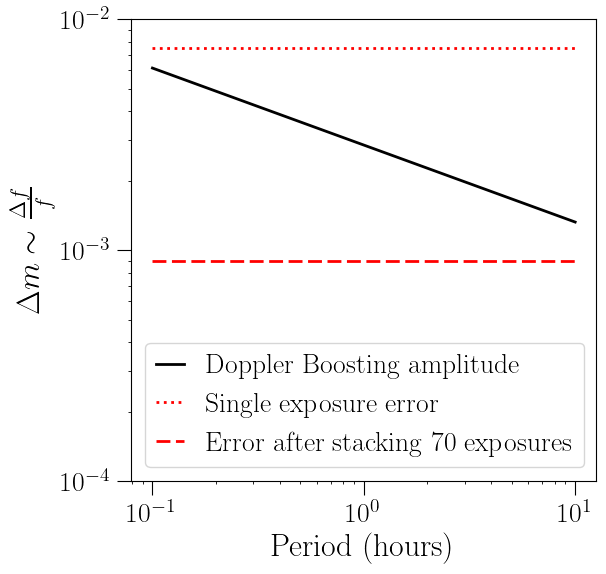

In [6]:
M1 = 0.3*units.M_sun
M2 = 0.6*units.M_sun
T1 = 10000*units.K
T2 = 7500*units.K
logg1 = mass_logteff_logg_DA([M1/units.M_sun],np.log10([T1/units.K]))[0]
logg2 = mass_logteff_logg_DA([M2/units.M_sun],np.log10([T2/units.K]))[0]
R1 = f_mass_logg_to_R(M1,logg1)
R2 = f_mass_logg_to_R(M2,logg2)

inclination = 60*units.degree
source_magnitude = 20

t_period = np.linspace(0.1,10,100)
plt.loglog(t_period,f_ADoppler(M1,M2,R1,R2,T1,T2,t_period*units.hour,inclination,waveband=band_wavelengths['r']),\
           '-',c='k',lw=2,label='Doppler Boosting amplitude')
#plt.loglog(t_period,f_AEllipsoidal(M1,M2,R1,T1,t_period*units.hour,inclination,waveband=band_wavelengths['r']),':',c='C1',label='Ellipsoidal Variation')


error_singleExposure = sigma1(source_magnitude,'r')
error_binned = sigma1(source_magnitude,'r')/(70)**0.5

plt.hlines(error_singleExposure,t_period.min(),t_period.max(),\
           label=r'Single exposure error',color='r',ls=':',lw=2)

plt.hlines(error_binned,t_period.min(),t_period.max(),\
           label=r'Error after stacking 70 exposures',color='r',ls=(0, (5, 2)),lw=2)

#plt.fill_between(t_period,error_binned,error_singleExposure,color='grey',alpha=0.2)

plt.xlabel('Period (hours)')
plt.ylabel(r'$\Delta m \sim \frac{\Delta f}{f}$')
plt.legend(loc='lower left')
#plt.title(f'{source_magnitude:.0f} magnitude target\nM1={M1:.2f} , T1={T1:.0f} , R1={R1:.2f} ,\n \
#M2={M2:.1f} , i={inclination:.0f}',fontsize=15);

plt.ylim(1e-4,1e-2)
plt.savefig('02_Results/dopplerBeaming.pdf',bbox_inches='tight')


# Observations
- Observations that are within 3.5'/2 of the field coordinate is considered to be observed
- First observation MJD is set as the zero point
- Each observation is assigned the field m5 value to calcuate the error in fractional flux
- Each observation has an associated filter

## Variation amplitude for a selected source

In [7]:
M1 = 0.6*units.M_sun
M2 = 0.6*units.M_sun
T1 = 15000*units.K
T2 = 2500*units.K
logg1 = mass_logteff_logg_DA([M1/units.M_sun],np.log10([T1/units.K]))[0]
logg2 = mass_logteff_logg_DA([M2/units.M_sun],np.log10([T2/units.K]))[0]
R1 = f_mass_logg_to_R(M1,logg1)
R2 = f_mass_logg_to_R(M2,logg2)
Period = 30*units.minute

inclination = 60*units.degree
source_magnitude = 18.

waveband = band_wavelengths['y']
variationAmplitude = f_AEllipsoidal(M1,M2,R1,T1,Period,inclination)
variationAmplitude = f_ADoppler(M1,M2,R1,R2,T1,T2,Period,inclination,waveband)
#variationAmplitude = f_ARelfection(M1,M2,R1,R2,T1,T2,Period,inclination,waveband)

t_ra,t_dec = np.random.choice(df_table['fieldRA','fieldDec'])
source_coordinate = SkyCoord(t_ra*units.deg,t_dec*units.deg)
Period = Period
observation_filters = list('ugrizy')
source_magnitude = dict(zip(observation_filters,[source_magnitude for _ in observation_filters]))
maximum_period = 50*units.hour
minimum_period = 10*units.minute
lightcurve_bins = 10
random_seed = np.random.randint(0,1000)
nterms = 1

print(f'{variationAmplitude*2:.4f}',f'{variationAmplitude:.4f}',\
      f"{np.round([sigma1(source_magnitude[band],band) for band in observation_filters],3)}")

0.0072 0.0036 [0.006 0.005 0.005 0.005 0.006 0.007]


## Multiband observations

In [66]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

def lightcurve_SimulationAndRecover_plotting(timeObs, fluxObs, e_fluxObs, bandObs,\
                                            ell_lightcurve_folded, ell_periodogram,\
                                             Period, model_ell_lightcurve_folded,\
                                             bestfit_ell_lightcurve_folded,falseAlarmProbab):
    #######################################
    # Plotting
    #######################################
    
    fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(12,6),tight_layout=True)
    
    # Plot Lightcurve
    
    model_ell_lightcurve_folded.scatter(ax=ax[0],label='Simulation model',xlabel='Phase',color='r',lw=2)
    bestfit_ell_lightcurve_folded.plot(ax=ax[0],label='Bestfit model',xlabel='Phase',color='blue',lw=2)
    ell_lightcurve_folded.errorbar(alpha=0.2,marker='o',c='grey',lw=5,ax=ax[0],label='Raw Lightcurve',xlabel='Phase',zorder=-1)
    ell_lightcurve_folded.bin(bins=lightcurve_bins).errorbar(color='k',marker='o',ms=5,lw=2,ax=ax[0],label='Binned lightcurve',xlabel='Phase')
    print(np.median(ell_lightcurve_folded.flux_err),\
          np.median(ell_lightcurve_folded.flux_err)/(len(ell_lightcurve_folded.flux_err)/10)**0.5,\
          np.median(ell_lightcurve_folded.bin(bins=lightcurve_bins).flux_err))
    ax[0].set_ylim(-np.percentile(fluxObs,99.9),np.percentile(fluxObs,99.9))

    ax[0].set_xticks([min(ell_lightcurve_folded.time.value),0,max(ell_lightcurve_folded.time.value)],
                     labels=[-0.5,0,0.5])
    
    ax_ins = inset_axes(ax[0], width="45%", height="24%", loc='lower right',)
   
    model_ell_lightcurve_folded.scatter(ax=ax_ins,xlabel='',ylabel='',color='r',lw=1.5)
    bestfit_ell_lightcurve_folded.plot(ax=ax_ins,xlabel='',color='blue',ylabel='',lw=1.5)
    ell_lightcurve_folded.bin(bins=lightcurve_bins).errorbar(color='k',marker='o',ms=3,lw=1.5,ax=ax_ins,xlabel='',ylabel='',)

    #mark_inset(ax[0], ax_ins, loc1=3, loc2=4, fc="none", ec="k",zorder=-1)
    ax_ins.set_xticks([])
    ax_ins.set_yticks([])
    
    # Plot periodogram
    
    ell_periodogram.plot(view='period',scale='log',ax=ax[1],color='k',lw=1.5)
    ax[1].set_yscale('linear')
    _ymin,_ymax = ax[1].set_ylim()
    _xmin,_xmax = ax[1].set_xlim()
    #ax[1].vlines(Period.to(ell_periodogram.period_at_max_power.unit).value,_ymin,_ymax,ls=':',label=f'Period = {Period.to(units.hour):.2f} \
    #                    \nBest Fit = {ell_periodogram.period_at_max_power.to(units.hour):.2f} ',color='r')
    
    #ax[1].hlines(y=ell_periodogram.max_power,xmax=_xmax,xmin=Period.to(ell_periodogram.period_at_max_power.unit).value,\
    #             ls='--',lw=2,label=f'Period = {Period.to(units.hour):.2f} \
    #                    \nBest Fit = {ell_periodogram.period_at_max_power.to(units.hour):.2f} ',color='r')

    temp_period1 = Period.to(ell_periodogram.period_at_max_power.unit).value
    temp_period2 = ell_periodogram.period_at_max_power.value
    
    ax[1].vlines(temp_period1, _ymin, _ymax, ls='--', color='red',\
               label=f'True Period = {Period.to(units.hour):.2f}',zorder=-1,lw=4,alpha=0.5)

    ax[1].arrow(_xmax, ell_periodogram.max_power*0.75, \
                temp_period2-_xmax+10**(np.log10(temp_period2)+np.log10(_xmax/_xmin)/20), 0, \
                head_width=(_ymax - _ymin)/40, lw=(_ymax - _ymin)/100, \
                head_length=10**(np.log10(temp_period2)+np.log10(_xmax/_xmin)/20-0.05), fc='grey', ec='darkgrey',\
               label=f'Best Fit Period = {ell_periodogram.period_at_max_power.to(units.hour):.2f}\
                       \nFalse Alarm Probability = {falseAlarmProbab:.1e}')
    
    ax[0].legend(framealpha=1,fontsize=15, loc='lower left')
    ax[1].legend(framealpha=1,fontsize=15, loc='lower left')
    
    return fig

#def validatePeriod(ell_periodogram,Period):
#    return max(np.abs(ell_periodogram.period[(ell_periodogram.max_power-ell_periodogram.power)<2] - Period)) < Period*0.1

def validatePeriod(ell_periodogram,Period):
    return np.abs(ell_periodogram.period_at_max_power - Period) < Period*0.1

def combined_astropy(timeObs, fluxObs, e_fluxObs, model_fluxObs, bandObs, Period, nterms, plot):
    
    #######################################
    # LombScargle astropy Periodogram
    #######################################
    
    model = LombScargle(t=timeObs, y=fluxObs, dy=e_fluxObs, nterms=nterms)
    frequency,power = model.autopower(minimum_frequency=1/maximum_period.to(units.hour),\
                                      maximum_frequency=1/minimum_period.to(units.hour),\
                                      method="fastnifty")
    
    best_frequency = frequency[np.argmax(power)]
    t_fit = np.linspace(0, best_frequency**-1)%best_frequency**-1
    y_fit = model.model(t_fit, best_frequency)

    ell_lightcurve = lightkurve.LightCurve(time=(timeObs-min(timeObs))%best_frequency**-1,\
                                           flux=fluxObs,flux_err=e_fluxObs)
    ell_periodogram = lightkurve.periodogram.Periodogram(frequency=frequency,power=power)
    ell_lightcurve_folded = ell_lightcurve.fold(period=ell_periodogram.period_at_max_power)
    
    bestfit_ell_lightcurve = lightkurve.LightCurve(time=t_fit,\
                                                 flux=y_fit)
    bestfit_ell_lightcurve_folded = bestfit_ell_lightcurve.fold(period=ell_periodogram.period_at_max_power)
    
    model_ell_lightcurve = lightkurve.LightCurve(time=(timeObs-min(timeObs))%best_frequency**-1,\
                                                 flux=model_fluxObs)
    model_ell_lightcurve_folded = model_ell_lightcurve.fold(period=ell_periodogram.period_at_max_power)

    falseAlarmProbab = model.false_alarm_probability(power.max(),\
                                                     minimum_frequency=1/maximum_period.to(units.hour),\
                                                     maximum_frequency=1/minimum_period.to(units.hour))
    
    goodPeriod =  (falseAlarmProbab < 0.003)
    
    if plot:        
        fig = lightcurve_SimulationAndRecover_plotting(timeObs, fluxObs, e_fluxObs, bandObs,\
                                                ell_lightcurve_folded, ell_periodogram,\
                                                 Period, model_ell_lightcurve_folded,\
                                                       bestfit_ell_lightcurve_folded,falseAlarmProbab)
        
    return model,ell_lightcurve,ell_periodogram,ell_lightcurve_folded,goodPeriod,fig

def lightcurve_SimulationAndRecover(stellar_params=[M1,M2,R1,R2,T1,T2,Period,inclination],\
                        source_coordinate=source_coordinate,\
                        observation_filters=observation_filters,\
                        source_magnitude=source_magnitude,\
                        maximum_period=maximum_period,\
                        minimum_period=minimum_period,\
                        lightcurve_bins=lightcurve_bins,\
                        random_seed=random_seed,\
                        nterms=nterms,\
                        model='combined_astropy',\
                        plot=True):

    np.random.seed(random_seed)

    M1,M2,R1,R2,T1,T2,Period,inclination = stellar_params
    
    #######################################
    # Select LSST observations
    #######################################
    
    observations = df_table[np.array((source_coordinate.separation(df_table['field_coordinates'])).value)<3.5/2]['observationStartMJD','fiveSigmaDepth','filter']
    
    if len(observations) > 0:
        observations['observationStartMJD'] = observations['observationStartMJD'] - min(observations['observationStartMJD'])

        #######################################
        # Select observation bands
        #######################################

        observation_index = np.argwhere([observation_filter in observation_filters for observation_filter in observations['filter']])
        observation_index = observation_index[:,0]

        #######################################
        # Simulate Observations
        #######################################

        timeObs = (observations['observationStartMJD'][observation_index]*units.day).to(units.hour)
        timeObs = timeObs - timeObs.min()

        bandObs = observations['filter'][observation_index]

        variationAmplitude = [f_ADoppler(M1,M2,R1,R2,T1,T2,Period,inclination,band_wavelengths[band]) for band in bandObs]
        #variationAmplitude = [f_ARelfection(M1,M2,R1,R2,T1,T2,Period,inclination,band_wavelengths[band]) for band in bandObs]
        print(np.unique(variationAmplitude))
        
        phase = np.random.uniform(0,2*np.pi)
        
        model_fluxObs = f_sinusoidalFlux(timeObs,variationAmplitude,Period,phase)
        e_fluxObs = np.array([f_sinusoidalFluxError(source_magnitude[band],band,m5) for m5,band in observations['fiveSigmaDepth','filter'][observation_index]])
        fluxObs = np.random.normal(model_fluxObs,scale=e_fluxObs)
        #return timeObs,fluxObs,e_fluxObs

        print(np.median(e_fluxObs))
        
        if model == 'combined_astropy':
            model,ell_lightcurve,ell_periodogram,ell_lightcurve_folded,goodPeriod,fig = \
                    combined_astropy(timeObs, fluxObs, e_fluxObs, model_fluxObs, bandObs, Period, nterms, plot)
            return model,ell_lightcurve,ell_periodogram,ell_lightcurve_folded,goodPeriod,fig

    else:
        return None,None,None,None,-1,-1
    
def parallelize_simulation(params,plot=False,random_seed=1,output=0):
    M1,M2,R1,R2,T1,T2,Period,inclination,source_magnitude,source_coordinate,observation_filters = params

    model,ell_lightcurve,ell_periodogram,ell_lightcurve_folded,goodPeriod,fig = \
                        lightcurve_SimulationAndRecover(stellar_params=[M1,M2,R1,R2,T1,T2,Period,inclination],\
                                                        source_coordinate=source_coordinate,\
                                                        observation_filters=observation_filters,\
                                                        source_magnitude=source_magnitude,\
                                                        random_seed=random_seed,model='combined_astropy',\
                                                        plot=plot)

    if output == 1:
        return model,ell_lightcurve,ell_periodogram,ell_lightcurve_folded,goodPeriod,fig
    else:
        return goodPeriod,fig

[8.79162430e-05 3.04142931e-04 3.37445867e-04 3.50102176e-04
 3.58654597e-04 3.59279742e-04]
0.046544900702535585
0.046544900702535585 0.00518447264368928 0.009768023545650175


ValueError: too many values to unpack (expected 3)

/opt/miniconda3/envs/research_base/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/opt/miniconda3/envs/research_base/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


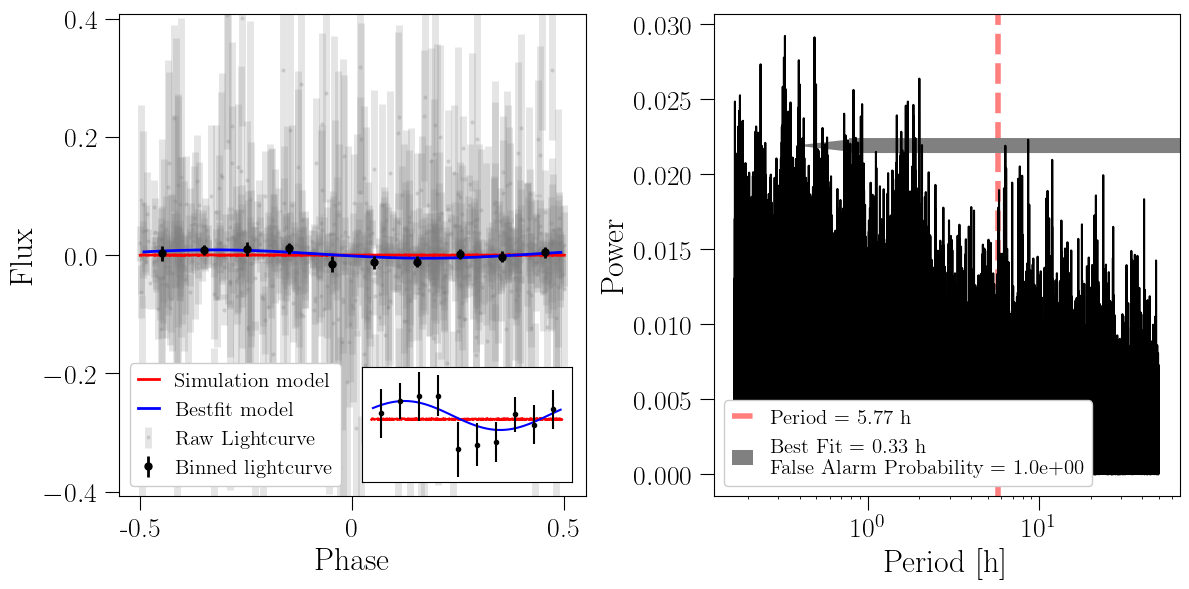

In [41]:
timeObs, fluxObs,e_fluxObs = lightcurve_SimulationAndRecover(stellar_params=[M1,M2,R1,R2,T1,T2,Period,inclination],\
                                                        source_coordinate=source_coordinate,\
                                                        observation_filters=observation_filters,\
                                                        source_magnitude=source_magnitude,\
                                                        maximum_period=maximum_period,\
                                                        minimum_period=minimum_period,\
                                                        lightcurve_bins=lightcurve_bins,\
                                                        nterms=1,\
                                                        random_seed=3,\
                                                        model='combined_astropy',\
                                                        plot=True)

In [ ]:
parallelize_simulation(recoverability[86],plot=True)

In [ ]:
source_magnitude = 18
observation_filters = list('ugrizy')
source_magnitude = dict(zip(observation_filters,[source_magnitude for _ in observation_filters]))

model,_,ell_periodogram,_,goodPeriod = \
                        lightcurve_SimulationAndRecover(stellar_params=[M1,M2,R1,R2,T1,T2,Period,inclination],\
                                                        source_coordinate=source_coordinate,\
                                                        observation_filters=observation_filters,\
                                                        source_magnitude=source_magnitude,\
                                                        maximum_period=maximum_period,\
                                                        minimum_period=minimum_period,\
                                                        lightcurve_bins=lightcurve_bins,\
                                                        nterms=1,\
                                                        random_seed=11,\
                                                        model='combined_astropy',\
                                                        plot=True)

print(len(model.y),goodPeriod)


# Analysis

In [ ]:
dataset = Table.read('./01_SeBa/01_results/GalacticDWDs.ecsv')
dataset.add_column(np.zeros(len(dataset)),name='beaming_detection')

In [ ]:
recoverability = []
recoverability_index = []

for ii_dwd in tqdm(range(len(dataset))):
    dwd = dataset[ii_dwd]
    Period = dwd['period_hour']*units.hour
    if Period < 1*units.hour and 17 < dwd['r'] and dwd['r'] < 21:
        M1 = dwd['M1']*units.M_sun
        M2 = dwd['M2']*units.M_sun
        R1 = dwd['R1']*units.R_sun
        R2 = dwd['R2']*units.R_sun
        T1 = 10**dwd['logTeff1']*units.K
        T2 = 10**dwd['logTeff2']*units.K
        inclination = dwd['inclination']*units.degree
        source_magnitude = {'u':dwd['u'],'g':dwd['g'],'r':dwd['r'],'i':dwd['i'],'z':dwd['z'],'y':dwd['y']}

        source_RA = dwd['RA_ICRS']*units.degree
        source_DEC = dwd['DEC_ICRS']*units.degree

        source_coordinate = SkyCoord(source_RA,source_DEC,frame='icrs')

        observation_filters = list('ugrizy')

        params = [M1,M2,R1,R2,T1,T2,Period,inclination,source_magnitude,source_coordinate,observation_filters]

        recoverability.append(params)
        
        recoverability_index.append(ii_dwd)

In [ ]:
len(recoverability)

In [ ]:
beaming = []
for ii_dwd in tqdm(range(len(recoverability))):
    beaming.append(parallelize_simulation(recoverability[ii_dwd]))
    
beaming = np.array(beaming)

In [ ]:
len(beaming[beaming>0])*4

In [ ]:
for ii in range(len(beaming)):
    dataset['beaming_detection'][recoverability_index[ii]] = beaming[ii]

# Plot beaming binaries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u

ra = dataset['RA_ICRS']
dec = dataset['DEC_ICRS']

print(len(ra))

# 2. Convert to radians and shift RA for Mollweide
# Mollweide expects:
# RA in radians: -pi to pi (longitude)
# Dec in radians: -pi/2 to pi/2 (latitude)
coords = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
ra_rad = coords.ra.wrap_at(180 * u.deg).radian
dec_rad = coords.dec.radian

# 3. Create the plot
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='mollweide')
ax.grid(True)

# 4. Scatter plot
ax.scatter(ra_rad, dec_rad, s=1, color='blue')

# Optional: Add axis labels
ax.set_xlabel('RA (rad)')
ax.set_ylabel('Dec (rad)')
plt.title('Mollweide Projection of RA/Dec')

plt.show()

In [ ]:
n_seed = 3

dataset = Table.read('./02_Results/GalacticDWDBeaming.ecsv')
dataset = dataset[(-0.00001<dataset['beaming_falseAlarmProbab'][:,n_seed])*\
                  (dataset['beaming_falseAlarmProbab'][:,n_seed]<1e-2)*\
                  (dataset['r']<22)*\
                  (np.abs(((dataset['beaming_period'][:,n_seed])-dataset['period_hour'])/\
                         dataset['period_hour'])>0.1)]

recoverability = []
recoverability_index = []

for ii_dwd in tqdm(range(len(dataset))):
    dwd = dataset[ii_dwd]
    Period = dwd['period_hour']*units.hour
    M1 = dwd['M1']*units.M_sun
    M2 = dwd['M2']*units.M_sun
    R1 = dwd['R1']*units.R_sun
    R2 = dwd['R2']*units.R_sun
    T1 = 10**dwd['logTeff1']*units.K
    T2 = 10**dwd['logTeff2']*units.K
    inclination = dwd['inclination']*units.degree
    source_magnitude = {'u':dwd['u'],'g':dwd['g'],'r':dwd['r'],'i':dwd['i'],'z':dwd['z'],'y':dwd['y']}

    source_RA = dwd['RA_ICRS']*units.degree
    source_DEC = dwd['DEC_ICRS']*units.degree

    source_coordinate = SkyCoord(source_RA,source_DEC,frame='icrs')

    observation_filters = list('ugrizy')

    params = [M1,M2,R1,R2,T1,T2,Period,inclination,source_magnitude,source_coordinate,observation_filters]

    recoverability.append(params)

In [ ]:
random_index = np.random.choice(range(len(recoverability)),size=min(5,len(recoverability)),replace=False)
random_index

In [ ]:
for ii_dwd in tqdm(range(len(random_index))):
    goodPeriod,fig = parallelize_simulation(recoverability[random_index[ii_dwd]],plot=True,random_seed=n_seed)
    print(goodPeriod)

In [10]:
dataset = Table.read('./02_Results/GalacticDWDBeaming.ecsv')

[0.00290432 0.00307484 0.00328369 0.00363809 0.0042963  0.00533066]
0.0062238201538373185
0.0062238201538373185 0.0006699642620941301 0.0009430644490894932
True
[0.00214807 0.00237082 0.00264668 0.00311822 0.0039902  0.0053217 ]
0.009393068618064167
0.009393068618064167 0.0010316448860205603 0.001636886308432007
True
[0.00170448 0.0018526  0.00203661 0.00235439 0.0029586  0.00393115]
0.019323301009748495
0.019323301009748495 0.002164472929004499 0.003986527897986588
True
[0.00093107 0.00099766 0.00108047 0.00122419 0.00150226 0.00196952]
0.02118984787990831
0.02118984787990831 0.002369097014617739 0.005457546847899298
False


/opt/miniconda3/envs/research_base/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/opt/miniconda3/envs/research_base/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/opt/miniconda3/envs/research_base/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/opt/miniconda3/envs/research_base/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/opt/miniconda3/envs/research_base/lib/python3.12/site-packages/IPython/core/pylabtools.

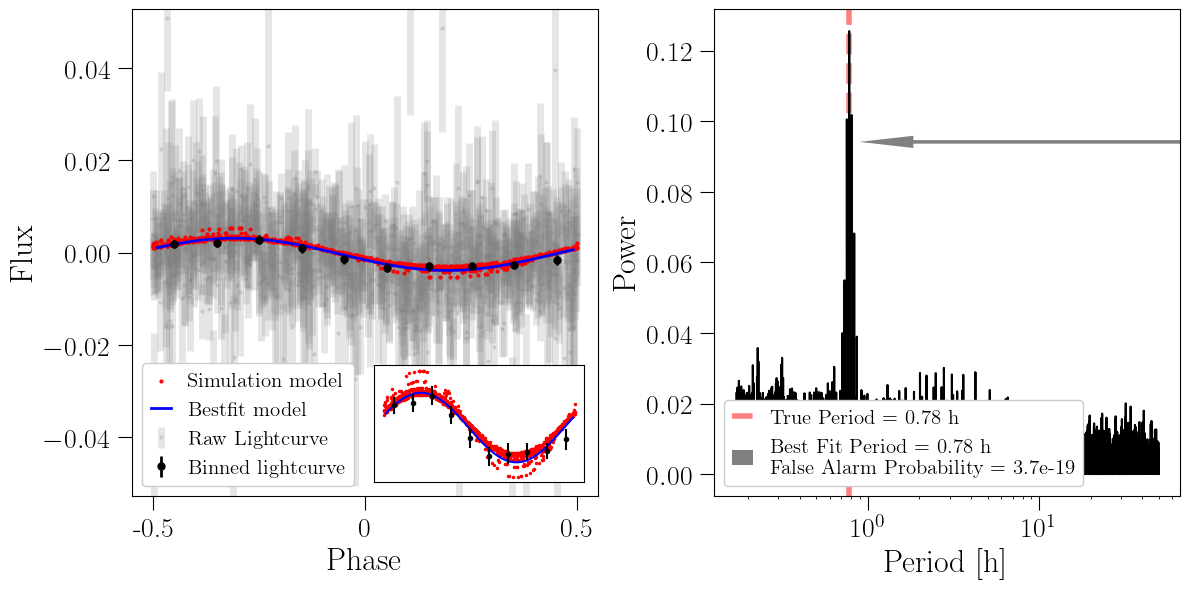

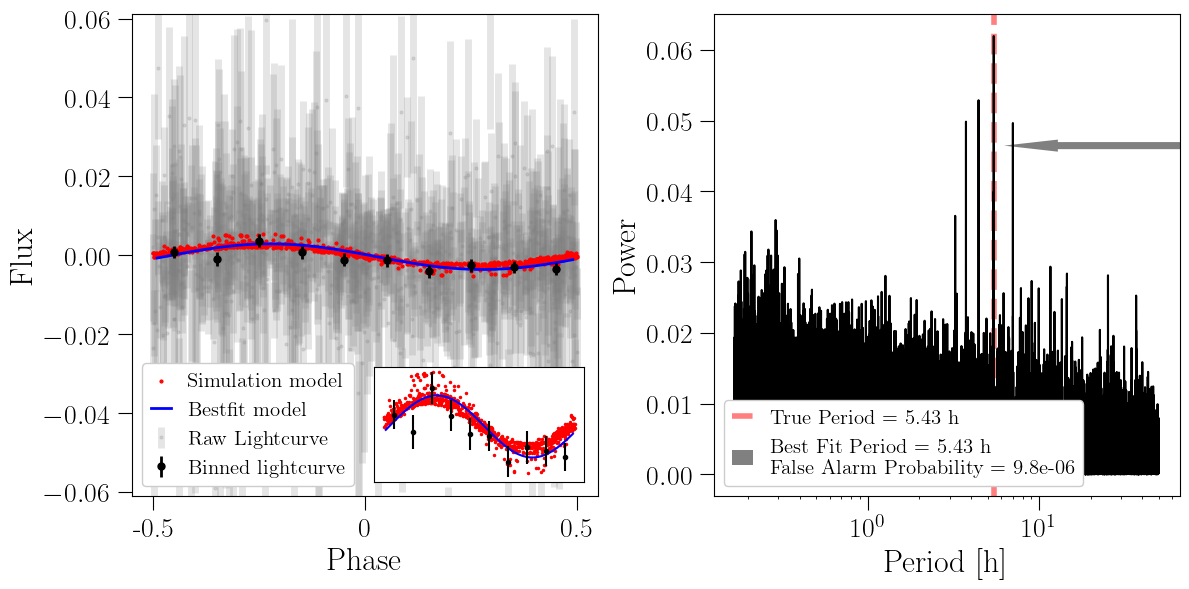

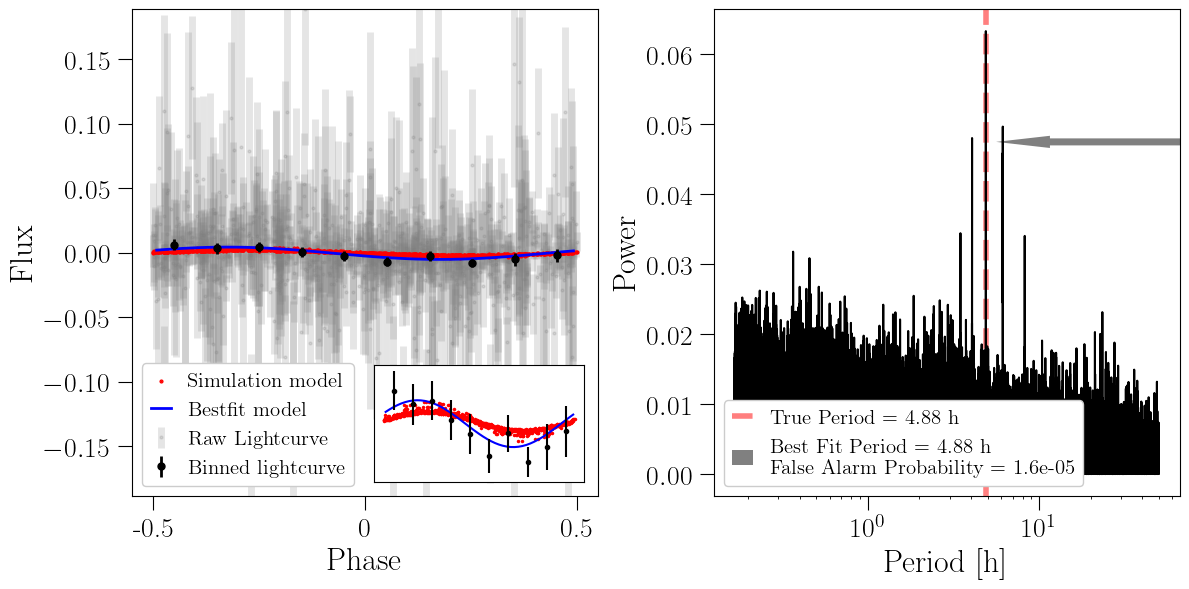

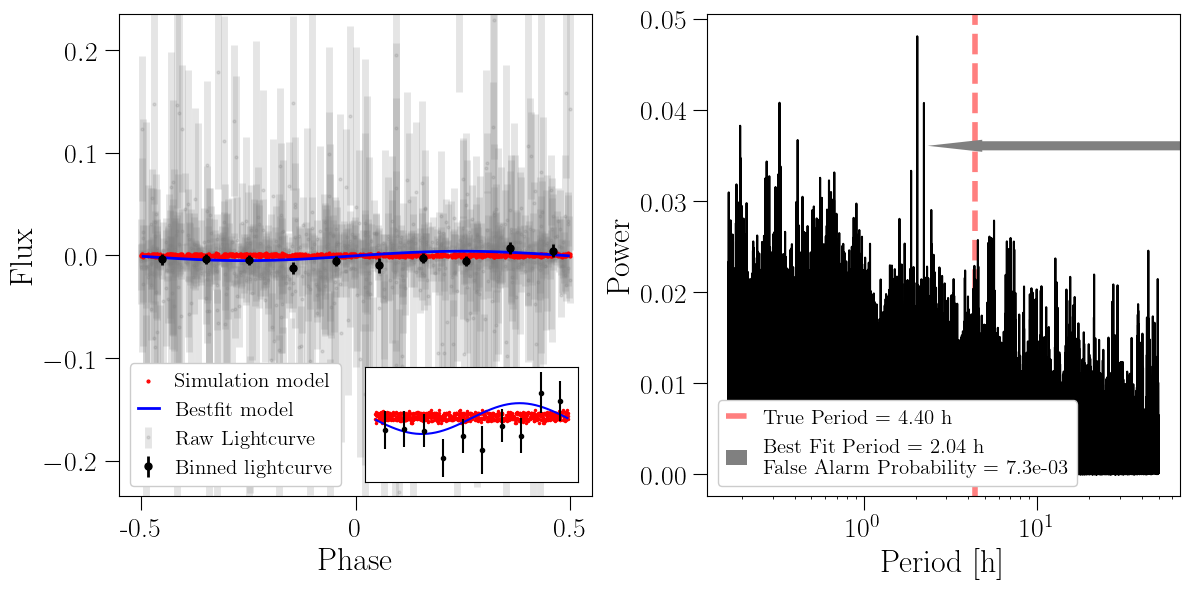

In [67]:
n_seed = 0

dataset_1 = dataset[(-0.03<dataset['beaming_falseAlarmProbab'][:,n_seed])*\
                  (dataset['beaming_falseAlarmProbab'][:,n_seed]<1e-14)][0]
dataset_2 = dataset[(1e-6<dataset['beaming_falseAlarmProbab'][:,n_seed])*\
                  (dataset['beaming_falseAlarmProbab'][:,n_seed]<1e-5)][4]
dataset_3 = dataset[(1e-5<dataset['beaming_falseAlarmProbab'][:,n_seed])*\
                  (dataset['beaming_falseAlarmProbab'][:,n_seed]<1e-4)][3]
dataset_4 = dataset[(4e-3<dataset['beaming_falseAlarmProbab'][:,n_seed])*\
                  (dataset['beaming_falseAlarmProbab'][:,n_seed]<1e-2)*\
                  (np.abs(((dataset['beaming_period'][:,n_seed])-dataset['period_hour'])/\
                         np.min([dataset['beaming_period'][:,n_seed],dataset['period_hour']]))<5.5)][0]

dwd = dataset_1
Period = dwd['period_hour']*units.hour
M1 = dwd['M1']*units.M_sun
M2 = dwd['M2']*units.M_sun
R1 = dwd['R1']*units.R_sun
R2 = dwd['R2']*units.R_sun
T1 = 10**dwd['logTeff1']*units.K
T2 = 10**dwd['logTeff2']*units.K
inclination = dwd['inclination']*units.degree
source_magnitude = {'u':dwd['u'],'g':dwd['g'],'r':dwd['r'],'i':dwd['i'],'z':dwd['z'],'y':dwd['y']}

source_RA = dwd['RA_ICRS']*units.degree
source_DEC = dwd['DEC_ICRS']*units.degree

source_coordinate = SkyCoord(source_RA,source_DEC,frame='icrs')

observation_filters = list('ugrizy')

params = [M1,M2,R1,R2,T1,T2,Period,inclination,source_magnitude,source_coordinate,observation_filters]

goodPeriod,fig_1 = parallelize_simulation(params,plot=True,random_seed=n_seed)
print(goodPeriod)

dwd = dataset_2
Period = dwd['period_hour']*units.hour
M1 = dwd['M1']*units.M_sun
M2 = dwd['M2']*units.M_sun
R1 = dwd['R1']*units.R_sun
R2 = dwd['R2']*units.R_sun
T1 = 10**dwd['logTeff1']*units.K
T2 = 10**dwd['logTeff2']*units.K
inclination = dwd['inclination']*units.degree
source_magnitude = {'u':dwd['u'],'g':dwd['g'],'r':dwd['r'],'i':dwd['i'],'z':dwd['z'],'y':dwd['y']}

source_RA = dwd['RA_ICRS']*units.degree
source_DEC = dwd['DEC_ICRS']*units.degree

source_coordinate = SkyCoord(source_RA,source_DEC,frame='icrs')

observation_filters = list('ugrizy')

params = [M1,M2,R1,R2,T1,T2,Period,inclination,source_magnitude,source_coordinate,observation_filters]

goodPeriod,fig_2 = parallelize_simulation(params,plot=True,random_seed=n_seed)
print(goodPeriod)

dwd = dataset_3
Period = dwd['period_hour']*units.hour
M1 = dwd['M1']*units.M_sun
M2 = dwd['M2']*units.M_sun
R1 = dwd['R1']*units.R_sun
R2 = dwd['R2']*units.R_sun
T1 = 10**dwd['logTeff1']*units.K
T2 = 10**dwd['logTeff2']*units.K
inclination = dwd['inclination']*units.degree
source_magnitude = {'u':dwd['u'],'g':dwd['g'],'r':dwd['r'],'i':dwd['i'],'z':dwd['z'],'y':dwd['y']}

source_RA = dwd['RA_ICRS']*units.degree
source_DEC = dwd['DEC_ICRS']*units.degree

source_coordinate = SkyCoord(source_RA,source_DEC,frame='icrs')

observation_filters = list('ugrizy')

params = [M1,M2,R1,R2,T1,T2,Period,inclination,source_magnitude,source_coordinate,observation_filters]

goodPeriod,fig_3 = parallelize_simulation(params,plot=True,random_seed=n_seed)
print(goodPeriod)

dwd = dataset_4
Period = dwd['period_hour']*units.hour
M1 = dwd['M1']*units.M_sun
M2 = dwd['M2']*units.M_sun
R1 = dwd['R1']*units.R_sun
R2 = dwd['R2']*units.R_sun
T1 = 10**dwd['logTeff1']*units.K
T2 = 10**dwd['logTeff2']*units.K
inclination = dwd['inclination']*units.degree
source_magnitude = {'u':dwd['u'],'g':dwd['g'],'r':dwd['r'],'i':dwd['i'],'z':dwd['z'],'y':dwd['y']}

source_RA = dwd['RA_ICRS']*units.degree
source_DEC = dwd['DEC_ICRS']*units.degree

source_coordinate = SkyCoord(source_RA,source_DEC,frame='icrs')

observation_filters = list('ugrizy')

params = [M1,M2,R1,R2,T1,T2,Period,inclination,source_magnitude,source_coordinate,observation_filters]

goodPeriod,fig_4 = parallelize_simulation(params,plot=True,random_seed=n_seed)
print(goodPeriod)

In [68]:
fig_1.savefig('02_Results/lc_best_fit_1.pdf',bbox_inches='tight')
fig_2.savefig('02_Results/lc_best_fit_2.pdf',bbox_inches='tight')
fig_3.savefig('02_Results/lc_best_fit_3.pdf',bbox_inches='tight')
fig_4.savefig('02_Results/lc_best_fit_4.pdf',bbox_inches='tight')

/var/folders/85/x0hqj_21233_0wt3y8p78bzc0000gn/T/ipykernel_62513/2066228521.py:1: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig_1.savefig('02_Results/lc_best_fit_1.pdf',bbox_inches='tight')
/var/folders/85/x0hqj_21233_0wt3y8p78bzc0000gn/T/ipykernel_62513/2066228521.py:2: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig_2.savefig('02_Results/lc_best_fit_2.pdf',bbox_inches='tight')
/var/folders/85/x0hqj_21233_0wt3y8p78bzc0000gn/T/ipykernel_62513/2066228521.py:3: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig_3.savefig('02_Results/lc_best_fit_3.pdf',bbox_inches='tight')
/var/folders/85/x0hqj_21233_0wt3y8p78bzc0000gn/T/ipykernel_62513/2066228521.py:4: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig_4.savefig(

In [ ]:
fig,ax = plt.subplots(nrows=2)

In [ ]:
len(dataset[100*np.abs(((dataset['beaming_period'][:,n_seed])-dataset['period_hour'])/\
                         np.min([dataset['beaming_period'][:,n_seed],dataset['period_hour']],axis=0))>50])

In [ ]:
np.min([dataset['beaming_period'][:,1],dataset['period_hour']],axis=0),dataset['period_hour']

In [ ]:
np.abs(((dataset['beaming_period'][:,1])-dataset['period_hour'])/\
                         np.min([dataset['beaming_period'][:,1],dataset['period_hour']],axis=0))[70]

In [ ]:
np.abs(((dataset['beaming_period'][:,1])-dataset['period_hour'])/dataset['period_hour'])[70]

In [ ]:
dataset = Table.read('./03_results/GalacticDWDBeaming.ecsv')
dataset = dataset[(dataset['u']<21)*(dataset['period_hour']<50)*\
                 (dataset['beaming_falseAlarmProbab']<0.003)]

display(len(dataset))

dataset = Table.read('./03_results/GalacticDWDBeaming.ecsv')
dataset = dataset[(dataset['u']<21)*(dataset['period_hour']<50)*\
                 (dataset['beaming_period']==-1)]

display(len(dataset))

In [ ]:
dataset = Table.read('./03_results/GalacticDWDBeaming.ecsv')
dataset = dataset[(dataset['beaming_falseAlarmProbab']<0.003)*(dataset['u']<20)]
                           
plt.hist(10**np.max(np.array([dataset['logTeff1'],dataset['logTeff2']]),axis=0))                          

In [ ]:
M1 = 0.6*units.M_sun
M2 = 0.6*units.M_sun
T1 = 10000*units.K
T2 = 5000*units.K

logg1 = mass_logteff_logg_DA([M1/units.M_sun],np.log10([T1/units.K]))[0]
logg2 = mass_logteff_logg_DA([M2/units.M_sun],np.log10([T2/units.K]))[0]
R1 = f_mass_logg_to_R(M1,logg1)
R2 = f_mass_logg_to_R(M2,logg2)
    
Period = 5*units.hour
inclination = 60*units.degree
source_magnitude = {'u':18,'g':18,'r':18,'i':18,'z':18,'y':18}

source_RA = 0*units.degree
source_DEC = -40*units.degree

source_coordinate = SkyCoord(source_RA,source_DEC,frame='icrs')

observation_filters = list('ugrizy')

params = [M1,M2,R1,R2,T1,T2,Period,inclination,source_magnitude,source_coordinate,observation_filters]

goodPeriod = parallelize_simulation(params,plot=True)
goodPeriod

In [ ]:
def f_mass_radius_to_logg(M_msun,R_rsun): 
    return np.log10((M_msun/R_rsun**2)) + 4.438

In [ ]:
teff_variable = np.linspace(8000,12000,20)

straight_line = lambda x,x1,y1,x2,y2: y1 + (x-x1)*(y2-y1)/(x2-x1)

check_within = lambda teff,logg : (logg>straight_line(teff,6200,4.2,13000,8.3))*\
                                    (logg<straight_line(teff,6000,4.3,12000,9.1))

logg_variable_low = straight_line(teff_variable,6200,4.2,13000,8.3)
logg_variable_high = straight_line(teff_variable,6000,4.3,12000,9.1)

In [ ]:
plt.plot(teff_variable,logg_variable_low)
plt.plot(teff_variable,logg_variable_high)

#plt.xscale('log')

bright1 = dataset['u1']<dataset['u2']
bright2 = dataset['u2']<dataset['u1']

teff = 10**dataset['logTeff1'][bright1]
M = dataset['M1'][bright1]
R = dataset['R1'][bright1]
logg = f_mass_radius_to_logg(M,R)

plt.scatter(teff,logg,label=check_within(teff,logg))

teff = 10**dataset['logTeff2'][bright2]
M = dataset['M2'][bright2]
R = dataset['R2'][bright2]
logg = f_mass_radius_to_logg(M,R)

plt.scatter(teff,logg,label=check_within(teff,logg))

#plt.legend()